In [1]:
!pip3 install albumentations

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from segmentation_models_pytorch import Unet


/Users/lilyreber/Downloads/severstal-steel-defect-detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/lilyreber/Downloads/severstal-steel-defect-detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def encoded_pixels_to_masks(fname: str, df: pd.DataFrame):
    fname_df = df[df['ImageId'] == fname]
    masks = np.zeros((256 * 1600, 4), dtype=np.float32) # float32 is V.Imp

    for i_row, row in fname_df.iterrows():
        cls_id = row['ClassId']
        encoded_pixels = row['EncodedPixels']
        if encoded_pixels is not np.nan:
            pixel_list = list(map(int, encoded_pixels.split(' ')))
            for i in range(0, len(pixel_list), 2):
                start_pixel = pixel_list[i] - 1
                num_pixel = pixel_list[i+1]
                masks[start_pixel:(start_pixel+num_pixel), cls_id-1] = 1

    masks = masks.reshape(256, 1600, 4, order='F')

    return masks

def masks_to_encoded_pixels(masks: np.ndarray):
    masks = masks.reshape(256*1600, 4, order='F')
    encoded_pixels_list = []
    for cls_id in range(4):
        cls_mask = masks[:, cls_id]
        cls_mask = cls_mask.reshape(256, 1600, order='F')
        cls_mask = cls_mask.T.flatten()
        prev_pixel = 0
        prev_pixel_val = 0
        encoded_pixels = []
        for i, pixel_val in enumerate(cls_mask):
            if pixel_val != prev_pixel_val:
                if pixel_val == 1:
                    start_pixel = i + 1
                    encoded_pixels.append(start_pixel - prev_pixel)
                else:
                    num_pixel = i - prev_pixel
                    encoded_pixels.append(num_pixel)
                prev_pixel = i
                prev_pixel_val = pixel_val
        encoded_pixels_list.append(encoded_pixels)
    return encoded_pixels_list # shape: 4x[]

### Sample example

In [90]:
train_val_csv = 'train.csv'
test_csv = 'test.csv'

df = pd.read_csv(train_val_csv)

df.ImageId

0       0002cc93b.jpg
1       0007a71bf.jpg
2       000a4bcdd.jpg
3       000f6bf48.jpg
4       0014fce06.jpg
            ...      
7090    ffcf72ecf.jpg
7091    fff02e9c5.jpg
7092    fffe98443.jpg
7093    ffff4eaa8.jpg
7094    ffffd67df.jpg
Name: ImageId, Length: 7095, dtype: object

In [5]:
# let's look at encoded pixels for the first image
img_id = '0002cc93b.jpg'
df[df.ImageId==img_id]

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...


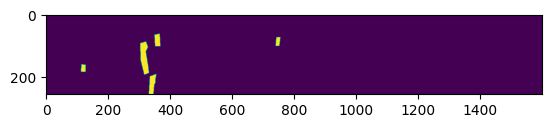

In [6]:
masks = encoded_pixels_to_masks(img_id, df, )
plt.imshow(masks[:,:,0]*255)

In [7]:
img = Image.open(os.path.join('train_images',img_id))

In [8]:
np.array(img).shape

(256, 1600, 3)

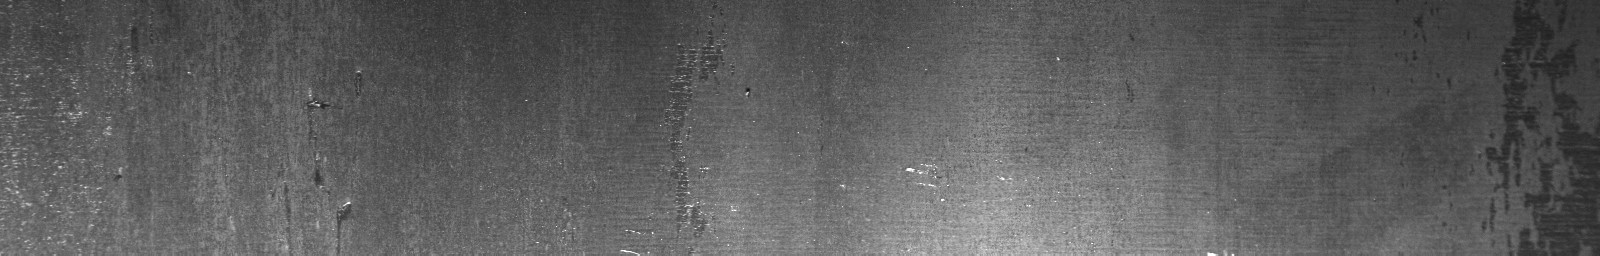

In [9]:
img

In [10]:
# let's encode masks back to encoded pixels
np.array(masks_to_encoded_pixels(masks)[0])

array([29102,    12,   233,    24,   233,    24,   233,    24,   233,
          24,   233,    24,   233,    24,   233,    24,   234,    23,
         234,    23,   234,    23,   234,    23,   234,    23,   234,
          23,   234,    23, 45221,    27,   230,    55,   201,    60,
         197,    64,   193,    68,   189,    72,   184,    77,   180,
          81,   176,    85,   172,    89,   167,    94,   163,    98,
         159,   102,   154,   105,   152,   105,   152,   104,   153,
         104,   152,   105,   152,    31,     5,    69,   155,    27,
          13,    63,   158,    22,    21,    57,   161,    17,    29,
          50,   164,    13,    37,    44,   167,     8,    45,    37,
         171,     3,    53,    31,   232,    25,   238,    18,   249,
           8,   314,    10,   228,    29,   210,    47,   200,    57,
         200,    57,   199,    58,   199,    58,   199,    58,   198,
          59,   198,    59,   198,    59,   197,    60,   197,    60,
         197,    60,

### Your code starts from here

In [4]:
class SeverstalSteelDataset(Dataset):
    def __init__(self, fnames, df, img_dir, transform=None, resized_size=(256, 256)):
        self.df = df
        self.img_dir = img_dir
        self.fnames = fnames
        self.transform = transform
        self.resized_size = resized_size
        self.mask_cache = {}

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_id = self.fnames[idx]
        img_path = os.path.join(self.img_dir, img_id)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.resized_size, interpolation=cv2.INTER_AREA)

        if img_id in self.mask_cache:
            masks = self.mask_cache[img_id]
        else:
            masks = encoded_pixels_to_masks(img_id, self.df)

            masks_resized = []
            for i in range(4):
                mask_channel = cv2.resize(masks[:, :, i], self.resized_size, interpolation=cv2.INTER_NEAREST)
                masks_resized.append(mask_channel)
            masks = np.stack(masks_resized, axis=2)
            self.mask_cache[img_id] = masks

        if self.transform:
            augmented = self.transform(image=img, mask=masks)
            img = augmented['image']
            masks = augmented['mask']

        img = torch.tensor(img, dtype=torch.float32)
        masks = torch.tensor(masks, dtype=torch.float32).permute(2, 0, 1)
        return img, masks, img_id

def collate_fn(batch):
    images, masks, fnames = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks, list(fnames)


In [5]:
class SegModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(SegModel, self).__init__()
        self.model = Unet(
            encoder_name='resnet34',
            encoder_weights='imagenet',
            classes=num_classes,
            activation=None
        )

    def forward(self, x):
        return self.model(x)

In [6]:
def load_data(train_val_csv, test_csv, train_val_img_dir, test_img_dir,
                    img_size=(256, 256), batch_size=8):
    train_val_df = pd.read_csv(train_val_csv)
    train_val_fnames = pd.unique(train_val_df.ImageId)
    test_df = pd.read_csv(test_csv)
    test_fnames = pd.unique(test_df.ImageId)

    train_size = int(0.8 * len(train_val_fnames))

    train_fnames = train_val_fnames[:train_size]
    val_fnames = train_val_fnames[train_size:]

    train_transform = A.Compose([
        A.HorizontalFlip(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    val_transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    train_dataset = SeverstalSteelDataset(
        train_fnames, train_val_df, train_val_img_dir,
        transform=train_transform, resized_size=img_size
    )
    val_dataset = SeverstalSteelDataset(
        val_fnames, train_val_df, train_val_img_dir,
        transform=val_transform, resized_size=img_size
    )
    test_dataset = SeverstalSteelDataset(
        test_fnames, test_df, test_img_dir,
        transform=val_transform, resized_size=img_size
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)

    return train_loader, val_loader, test_loader

In [7]:
def dice_score(pred, target, smooth=1e-6):
    pred = pred
    target = target
    intersection = (pred * target).sum()
    return (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [8]:
def init_model(num_classes=4):
    model = SegModel(num_classes=num_classes)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    return model, criterion, optimizer


def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    model.to(device)
    model.train()

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (images, masks, _) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        model.eval()
        val_loss = 0.0
        dice_scores = []

        with torch.no_grad():
            for images, masks, _ in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs) > 0.5
                batch_size = images.size(0)
                for i in range(batch_size):
                    for class_id in range(4):
                        dice = dice_score(preds[i, class_id], masks[i, class_id])
                        dice_scores.append(dice.item())

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_dice = np.mean(dice_scores)

        scheduler.step()

        print(f'Epoch {epoch}  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}')
        print(f'  ----->  Val Mean Dice score: {avg_dice:.4f}  <-----')
        print('-' * 66)

    return model


In [11]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

train_loader, val_loader, test_loader = load_data('train.csv', 'sample_submission.csv',  'train_images', 'test_images',
                                                            img_size=(256, 256), batch_size=4)

model, criterion, optimizer = init_model()

train(model, criterion, optimizer, train_loader, val_loader, epochs=15, device=device)

torch.save(model.state_dict(), 'steel_defect_model.pth')


/var/folders/sf/rty_86tx72v8n3bfz11wwv400000gn/T/ipykernel_4518/200541774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/var/folders/sf/rty_86tx72v8n3bfz11wwv400000gn/T/ipykernel_4518/200541774.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(masks, dtype=torch.float32).permute(2, 0, 1)


Epoch: 0, Batch: 0/1333, Loss: 0.8477
Epoch: 0, Batch: 10/1333, Loss: 0.5108
Epoch: 0, Batch: 20/1333, Loss: 0.3260
Epoch: 0, Batch: 30/1333, Loss: 0.2253
Epoch: 0, Batch: 40/1333, Loss: 0.1497
Epoch: 0, Batch: 50/1333, Loss: 0.1144
Epoch: 0, Batch: 60/1333, Loss: 0.0812
Epoch: 0, Batch: 70/1333, Loss: 0.0792
Epoch: 0, Batch: 80/1333, Loss: 0.1224
Epoch: 0, Batch: 90/1333, Loss: 0.0582
Epoch: 0, Batch: 100/1333, Loss: 0.0526
Epoch: 0, Batch: 110/1333, Loss: 0.1063
Epoch: 0, Batch: 120/1333, Loss: 0.0683
Epoch: 0, Batch: 130/1333, Loss: 0.0501
Epoch: 0, Batch: 140/1333, Loss: 0.0697
Epoch: 0, Batch: 150/1333, Loss: 0.0567
Epoch: 0, Batch: 160/1333, Loss: 0.0687
Epoch: 0, Batch: 170/1333, Loss: 0.0619
Epoch: 0, Batch: 180/1333, Loss: 0.0755
Epoch: 0, Batch: 190/1333, Loss: 0.1353
Epoch: 0, Batch: 200/1333, Loss: 0.0257
Epoch: 0, Batch: 210/1333, Loss: 0.0823
Epoch: 0, Batch: 220/1333, Loss: 0.1144
Epoch: 0, Batch: 230/1333, Loss: 0.0329
Epoch: 0, Batch: 240/1333, Loss: 0.0708
Epoch: 0, B

In [226]:
def evaluate(model, loader, device):
    model.eval()
    submission = []

    with torch.no_grad():
        count = 0
        for images, _, fnames in loader:
            images = images.to(device)
            outputs = model(images)

            preds = torch.sigmoid(outputs) > 0.5

            for i, m in enumerate(preds):
                pixels = []
                mask = m.permute(2, 1, 0).cpu().numpy().astype(np.uint8)
                mask = cv2.resize(mask, (256, 1600), interpolation=cv2.INTER_NEAREST)
                mask = torch.from_numpy(mask).permute(0, 1, 2).cpu().numpy().transpose(1, 0, 2)

                count += 1

                encoded_pixels = masks_to_encoded_pixels(mask)

                pixels = [(fnames[i], ' '.join(str(i) for i in m), c, mask) for c, m in enumerate(encoded_pixels) if m]
                submission.extend(pixels)


    submission_df = pd.DataFrame(submission, columns=['ImageId', 'EncodedPixels', 'ClassId', 'Mask'])
    submission_df.to_csv('submission.csv', index=False)
    return submission_df

In [227]:
submission_df = evaluate(model, val_loader, device)

/var/folders/sf/rty_86tx72v8n3bfz11wwv400000gn/T/ipykernel_4518/200541774.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
/var/folders/sf/rty_86tx72v8n3bfz11wwv400000gn/T/ipykernel_4518/200541774.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(masks, dtype=torch.float32).permute(2, 0, 1)


In [140]:
df = pd.read_csv('train.csv')

df.ImageId

0       0002cc93b.jpg
1       0007a71bf.jpg
2       000a4bcdd.jpg
3       000f6bf48.jpg
4       0014fce06.jpg
            ...      
7090    ffcf72ecf.jpg
7091    fff02e9c5.jpg
7092    fffe98443.jpg
7093    ffff4eaa8.jpg
7094    ffffd67df.jpg
Name: ImageId, Length: 7095, dtype: object

In [274]:
submission_df

,ImageId,EncodedPixels,ClassId,Mask
0,fa130006f.jpg,107376 45 62 15 8 5 124 45 62 15 8 5 124 45 62...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1,d0fb25531.jpg,20995 104 153 104 153 104 153 104 153 104 153 ...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
2,d3ef0c943.jpg,184068 39 8 82 129 39 8 82 129 39 8 82 129 39 ...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
3,ea675dd1e.jpg,347504 11 9 1 7 11 23 4 194 11 9 1 7 11 23 4 1...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
4,daacde94c.jpg,136201 73 184 73 184 73 184 73 184 73 184 73 1...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
...,...,...,...,...
1218,e9c57b010.jpg,248183 14 243 14 243 14 243 14 243 14 243 14 2...,3,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1219,ea13e9557.jpg,99374 2 255 2 255 2 255 2 255 2 255 2 254 3 25...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1220,d46866225.jpg,313612 16 13 57 172 16 13 57 172 16 13 57 172 ...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."
1221,def2e3f57.jpg,8246 20 35 38 165 20 35 38 165 20 35 38 165 20...,2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0..."


In [211]:
img_id = 'f78c3b312.jpg'

118418.0


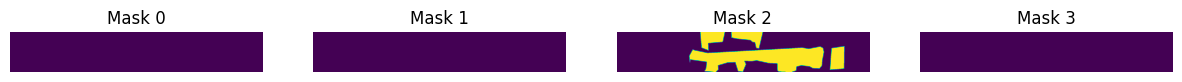

In [212]:
df[df.ImageId==img_id]

masks = encoded_pixels_to_masks(img_id, df, )
print(masks.sum())
plt.figure(figsize=(15,5))
for k in range(4):
    plt.subplot(1,4,k+1)
    plt.imshow(masks[..., k], )
    plt.title(f'Mask {k}')
    plt.axis('off')
plt.show()


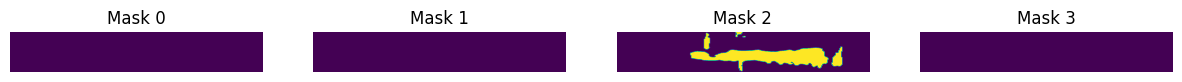

In [224]:
#masks = encoded_pixels_to_masks(img_id, submission_df, )
masks = submission_df[submission_df.ImageId == 'f78c3b312.jpg']['Mask'][1]
plt.figure(figsize=(15,5))
for k in range(4):
    plt.subplot(1,4,k+1)
    plt.imshow(masks[..., k], )
    plt.title(f'Mask {k}')
    plt.axis('off')
plt.show()


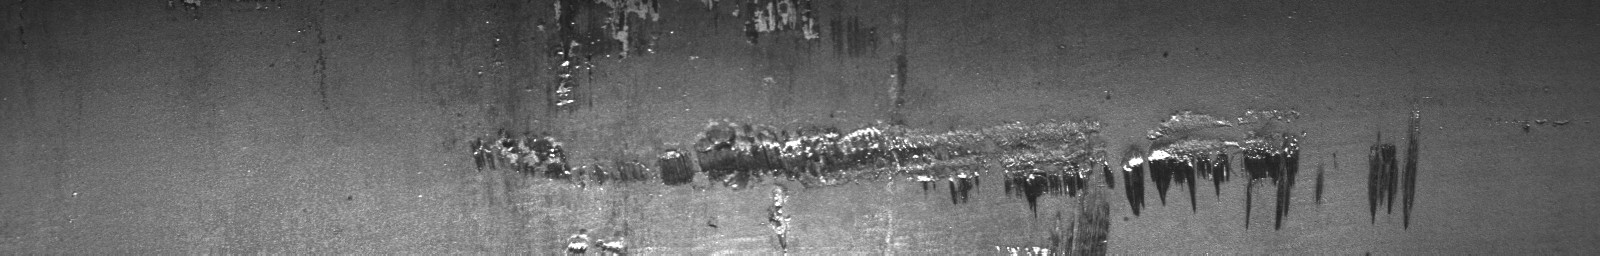

In [230]:
img = Image.open(os.path.join('train_images', 'f78c3b312.jpg'))
img

In [282]:
img_id = 'ea675dd1e.jpg'

57036.0


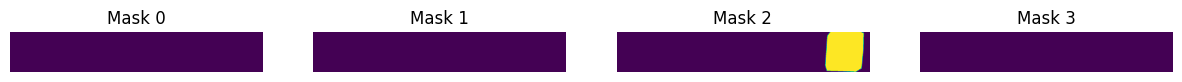

In [283]:
df[df.ImageId==img_id]

masks = encoded_pixels_to_masks(img_id, df, )
print(masks.sum())
plt.figure(figsize=(15,5))
for k in range(4):
    plt.subplot(1,4,k+1)
    plt.imshow(masks[..., k], )
    plt.title(f'Mask {k}')
    plt.axis('off')
plt.show()


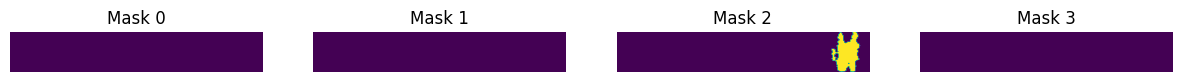

In [284]:
masks = submission_df[submission_df.ImageId == img_id]['Mask'].iloc[0]

plt.figure(figsize=(15,5))
for k in range(4):
    plt.subplot(1,4,k+1)

    plt.imshow(masks[..., k], )
    plt.title(f'Mask {k}')
    plt.axis('off')
plt.show()


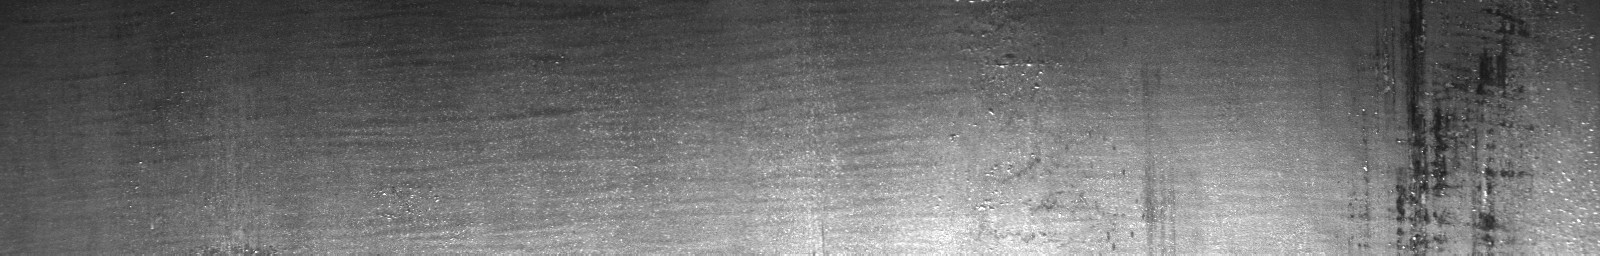

In [285]:
img = Image.open(os.path.join('train_images', img_id))
img